In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

data_path = 'data.csv'
data = pd.read_csv(data_path, sep=';')

df = pd.DataFrame(data)

# Interaction entre gares de départ et d'arrivée
df['ligne'] = df['gare_depart'] + "-" + df['gare_arrivee']

df['mois'] = df['date'].str.split('-').str[1]



X = df[['service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'nb_train_prevu', 'ligne', 'mois']]
y = df['retard_moyen_arrivee']

#Ajout du clustering

label_encoder = LabelEncoder()
interactions_encoded = label_encoder.fit_transform(df['ligne']).reshape(-1, 1)

# One-Hot Encoding pour les colonnes catégorielles
X_cluster = pd.get_dummies(df, columns=['date','gare_depart', 'gare_arrivee', 'service', 'ligne'])
X_cluster = X_cluster.drop(['commentaire_annulation', 'commentaire_retards_depart', 'commentaires_retard_arrivee'], axis=1)

k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster)

majority_class = {}
lignes= df['ligne'].unique()
for ligne in lignes:
    cluster_labels = df[df['ligne'] == ligne]['cluster'].tolist()
    majority_label = Counter(cluster_labels).most_common(1)[0][0]
    majority_class[ligne] = majority_label


df['majority_class'] = df['ligne'].map(majority_class)

X['majority_class'] = df['majority_class']


# One-Hot Encoding pour les colonnes catégorielles
X = pd.get_dummies(X, columns=['gare_depart', 'gare_arrivee', 'service', 'ligne'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle avec recherche d'hyperparamètres optimaux
param_grid = {
    'n_estimators': [10, 30, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 5, 10, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

param_grid_randomized = {
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 5, 10, 20, 50, 75],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'bootstrap': [True, False]
}


rf = RandomForestRegressor()

#grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
#grid_search.fit(X_train, y_train)

# Recherche aléatoire avec validation croisée
rf_search = RandomizedSearchCV(rf, param_distributions=param_grid_randomized, n_iter=200, cv=5, verbose=0, n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)

# Meilleurs hyperparamètres
print(rf_search.best_params_)

#y_pred_grid = grid_search.best_estimator_.predict(X_test)
y_pred_randomized = rf_search.best_estimator_.predict(X_test)

#mse_grid = mean_squared_error(y_test, y_pred_grid)
#print(f"Mean Squared Error with GridSearch: {mse_grid}")

mae = mean_absolute_error(y_test, y_pred_randomized)
mse_randomized = mean_squared_error(y_test, y_pred_randomized)
mape = mean_absolute_percentage_error(y_test, y_pred_randomized)
r2 = r2_score(y_test, y_pred_randomized)

print(f"Mean Squared Error with RandomizedSearch: {mse_randomized}")
print(f"Mean Absolute Error with RandomizedSearch: {mae}")
print(f"Mean Absolute Percentage Error with RandomizedSearch: {mape}")
print(f"R2 Score with RandomizedSearch: {r2}")





/Users/yanivbenchetrit/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/k3/qd4s2qb11n9bb6n5nsg_7mfc0000gn/T/ipykernel_84481/3798176489.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['majority_class'] = df['majority_class']
/Users/yanivbenchetrit/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
330 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, y

{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
Mean Squared Error with RandomizedSearch: 194.48542989967962
Mean Absolute Error with RandomizedSearch: 8.664203819112922
Mean Absolute Percentage Error with RandomizedSearch: inf
R2 Score with RandomizedSearch: 0.28108261937114387


/var/folders/k3/qd4s2qb11n9bb6n5nsg_7mfc0000gn/T/ipykernel_84481/3798176489.py:17: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Index(['duree_moyenne', 'nb_train_prevu', 'nb_annulation',
       'nb_train_depart_retard', 'retard_moyen_depart',
       'retard_moyen_tous_trains_depart', 'nb_train_retard_arrivee',
       'retard_moyen_arrivee', 'retard_moyen_tous_trains_arrivee',
       'nb_train_retard_sup_15',
       ...
       'ligne_STRASBOURG-PARIS EST', 'ligne_STUTTGART-PARIS EST',
       'ligne_TOULON-PARIS LYON', 'ligne_TOULOUSE MATABIAU-PARIS MONTPARNASSE',
       'ligne_TOURCOING-BORDEAUX ST JEAN',
       'ligne_TOURCOING-MARSEILLE ST CHARLES',
       'ligne_TOURS-PARIS MONTPARNASSE', 'ligne_VALENCE ALIXAN TGV-PARIS LYON',
       'ligne_VANNES-PARIS MONTPARNASSE', 'ligne_ZURICH-PARIS LYON'],
      dtype='object', length=338)


/Users/yanivbenchetrit/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yanivbenchetrit/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yanivbenchetrit/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yanivbenchetrit/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarni

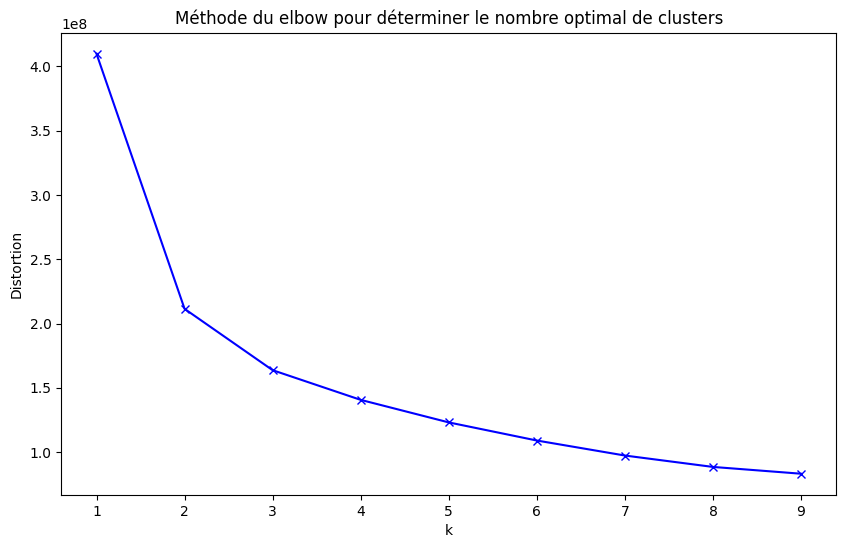

In [2]:
#Clustering par ligne

# Encodage des labels pour gare_interaction
label_encoder = LabelEncoder()
interactions_encoded = label_encoder.fit_transform(df['ligne']).reshape(-1, 1)

# One-Hot Encoding pour les colonnes catégorielles
X = pd.get_dummies(df, columns=['date','gare_depart', 'gare_arrivee', 'service', 'ligne'])
X = X.drop(['commentaire_annulation', 'commentaire_retards_depart', 'commentaires_retard_arrivee'], axis=1)

print(X.columns)

# Utilisation de la méthode du coude pour déterminer le nombre optimal de clusters
distortions = []
K = range(1, 10) # Vous pouvez ajuster la plage selon vos besoins
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Méthode du elbow pour déterminer le nombre optimal de clusters')
plt.show()


In [3]:
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

print(df[['ligne', 'cluster']])



majority_class = {}
lignes= df['ligne'].unique()
for ligne in lignes:
    cluster_labels = df[df['ligne'] == ligne]['cluster'].tolist()
    majority_label = Counter(cluster_labels).most_common(1)[0][0]
    majority_class[ligne] = majority_label


df['majority_class'] = df['ligne'].map(majority_class)

X['majority_class'] = df['majority_class']

print(X['majority_class'])

/Users/yanivbenchetrit/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                                       ligne  cluster
0        BORDEAUX ST JEAN-PARIS MONTPARNASSE        1
1       LA ROCHELLE VILLE-PARIS MONTPARNASSE        2
2                 PARIS MONTPARNASSE-QUIMPER        2
3                 PARIS MONTPARNASSE-ST MALO        0
4     PARIS MONTPARNASSE-ST PIERRE DES CORPS        2
...                                      ...      ...
8149                    STRASBOURG-PARIS EST        1
8150    TOULOUSE MATABIAU-PARIS MONTPARNASSE        0
8151                TOURS-PARIS MONTPARNASSE        2
8152           VALENCE ALIXAN TGV-PARIS LYON        1
8153               VANNES-PARIS MONTPARNASSE        2

[8154 rows x 2 columns]
0       1
1       2
2       2
3       0
4       1
       ..
8149    1
8150    0
8151    2
8152    2
8153    2
Name: majority_class, Length: 8154, dtype: int64
